In [20]:
print("hello world")

hello world


# 7.1回顾——AlexNet的结构——多层卷积设计

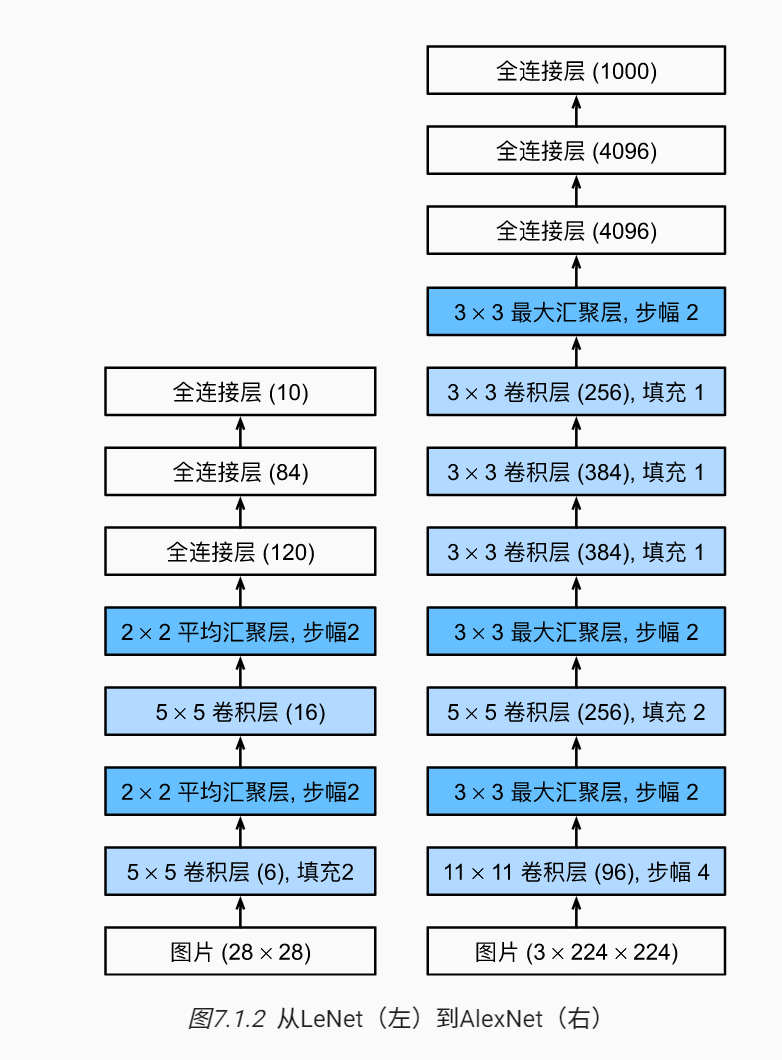

In [71]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\AlexNet.png",width=600,height=400)

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。这里使用Fashion-MNIST，所以输出的类别数为10
    nn.Linear(4096, 10))

In [9]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [4]:
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()


def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_utils`"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None): 
    #@save """下载Fashion-MNIST数据集，然后将其加载到内存中""" 
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
        trans = transforms.Compose(trans)
        mnist_train = torchvision.datasets.FashionMNIST(
            root="D:\Anaconda\data", train=True, transform=trans, download=True)
        mnist_test = torchvision.datasets.FashionMNIST(
            root="D:\Anaconda\data", train=False, transform=trans, download=True)
        return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                                num_workers=get_dataloader_workers()),
                data.DataLoader(mnist_test, batch_size, shuffle=False,
                                num_workers=get_dataloader_workers()))
    

In [6]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

loss 0.331, train acc 0.878, test acc 0.879
1053.5 examples/sec on cuda:0


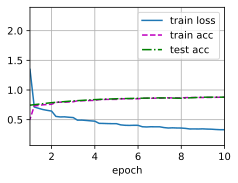

In [7]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.2 回顾——VGG的结构——模块化设计

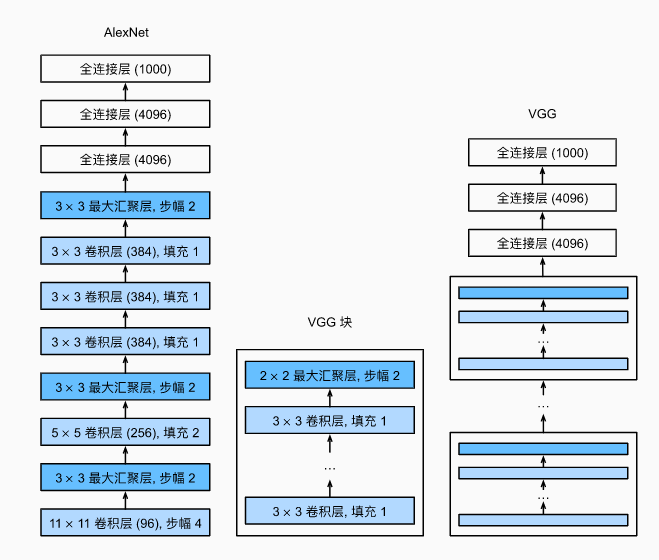

In [74]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\VGG.png",width=600,height=400)

### 7.2.1 定义VGG块

In [15]:
import torch
from torch import nn


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)  # 星号表示以元组形式传入，将每个元素拆开作为变量传入

### 7.2.2 VGG-11及其实现

VGG神经网络连接有超参数变量conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。下面的例子就是展示VGG-11

In [16]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [17]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [18]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 7.2.3 训练模型

loss 0.177, train acc 0.935, test acc 0.909
717.7 examples/sec on cuda:0


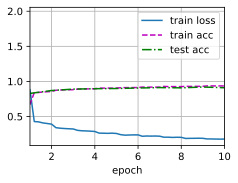

In [19]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.3 回顾——NiN的结构——全局平均池化的运用

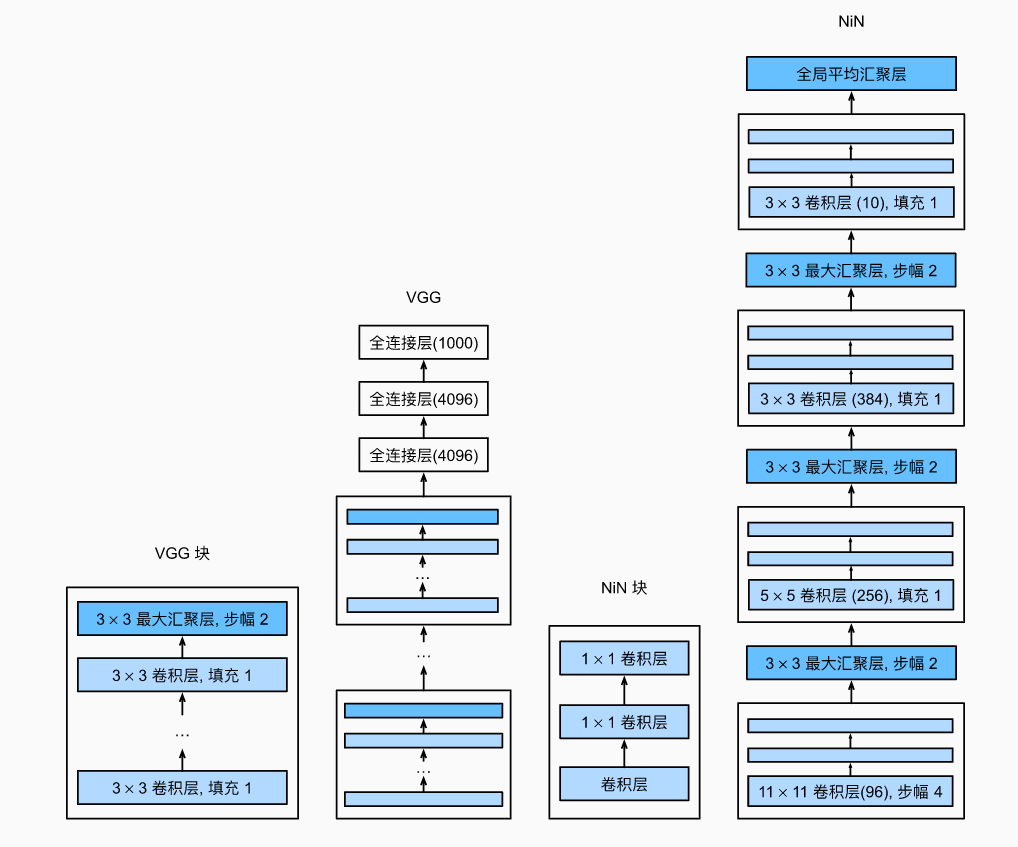

In [52]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\NiN.png",width=600,height=400)

### 7.3.1构造NiN块

In [20]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

构造NiN网络并查看输出形状

In [21]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


训练模型并查看结果

loss 0.427, train acc 0.842, test acc 0.849
999.3 examples/sec on cuda:0


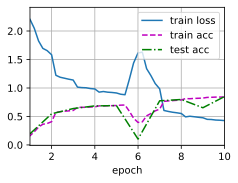

In [22]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.4 回顾——GoogLeNet的结构——从串联走向并联

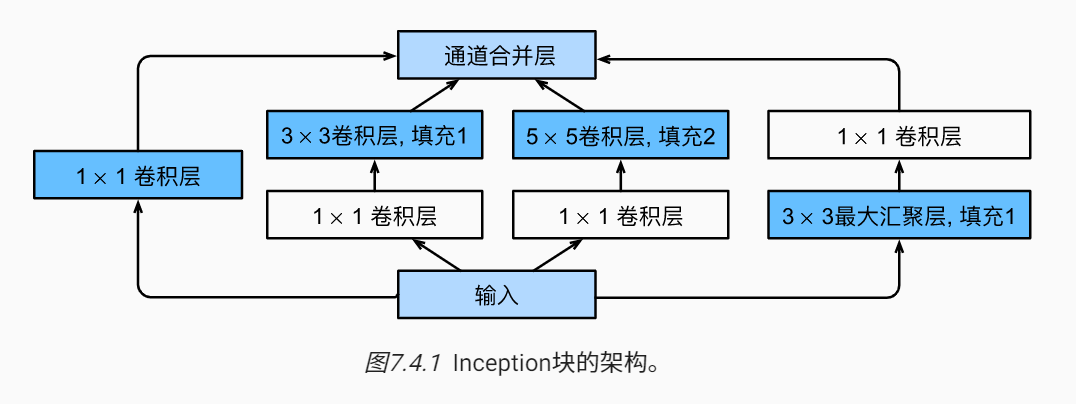

In [43]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\Inception块.png",width=800,height=400)

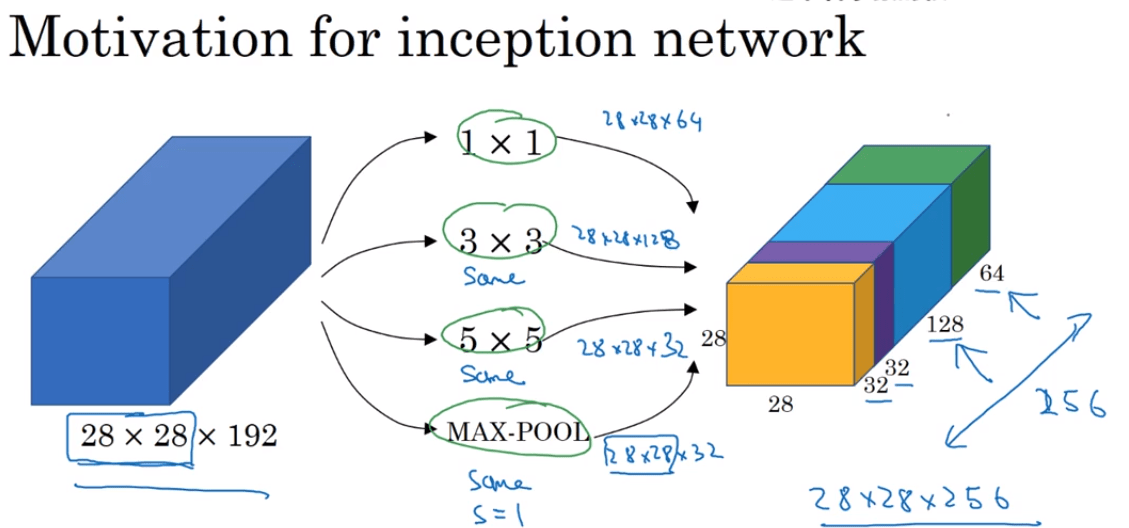

In [75]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\GN的加法.png",width=600,height=400)

## 7.4.1 构造Inception块

In [24]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

## 7.4.2 GoogLeNet结构及其实现

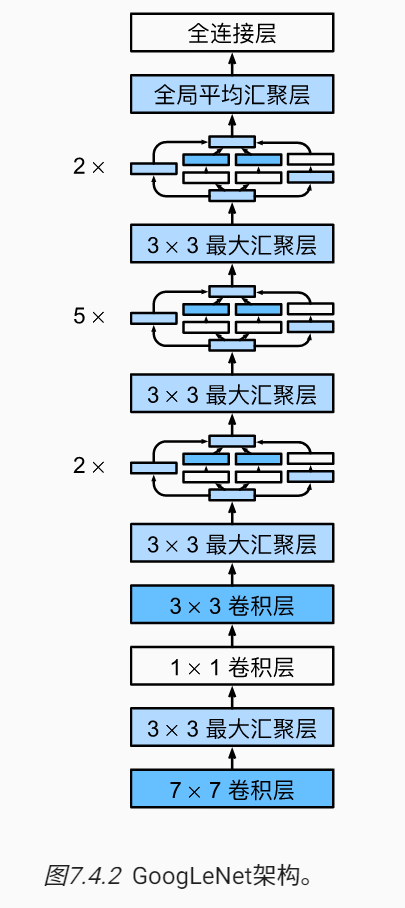

In [52]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\GoogLeNet.png",width=400,height=400)

构造GoogLeNet网络——分五个模块实现上图的架构

第一个模块使用64个通道、7X7卷积层，再接上激活函数和最大池化层

In [25]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第二个模块使用两个卷积层：第一个卷积层是64个通道、卷积层；第二个卷积层使用将通道数量增加三倍的卷积层。最后接上最大池化层。

In [26]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

模块三是串联两个Inception块

In [27]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

模块四是串联五个Inception块

In [28]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

模块五是两个Inception块加上全局平均池化层和全连接的输出层

In [29]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

在例子中将Fashion-MNIST输入的高和宽从224降到96，简化了计算，使训练更快。

In [30]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## 7.4.3 输入数据集运行结果

loss 0.242, train acc 0.908, test acc 0.898
124.2 examples/sec on cuda:0


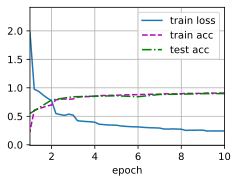

In [31]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.5 批量规范化——基于批量统计的标准化

## 为什么要做批量规范化？
1. 它可以将参数的量级进行统一
2. 批量规范化的发明者非正式地假设，随着迭代的进行变量分布的偏移可能会阻碍网络的收敛。
3. 更深层的网络很复杂，容易过拟合。——规范化基于随机批量，将训练数据打乱

## 副作用
不管原分布如何，归一化之后的分布被强制拉到均值为0和标准差为1的正态分布上来，一定程度上降低了模型的拟合能力

## 7.5.1 批量标准化的含义

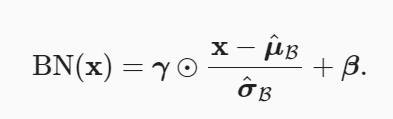

In [12]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\批量规范化公式.png",width=400,height=400)

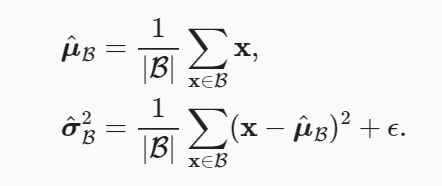

In [13]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\批量规范化均值和标准差.png",width=400,height=400)

在方差估计值中添加一个小的大于0的常量，以确保不会除以零。注意采用的是移动平均法，下面代码会讲

批量规范化函数写法如下：

In [14]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum): #momentum是决定做移动平均时的比例
    # 通过autograd来判断当前模式是训练模式还是预测模式
    if not autograd.is_training():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / np.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean, moving_var

简明实现方法——在序列设计中输入nn.BatchNorm

# 7.6 残差网络 ResNet

## 核心思想
   每个附加层都应该更容易地包含原始函数作为其元素之一；随着网络层次的增加，不应当使网络性能变差
   
## 优点：
1. 通过跳跃连接加快正向传播速度，使得网络层次可以更多
2. 因为BN和残差估计的方法限制了特征值的大小，加之反向传播求梯度时有了加项，一定程度上缓解了梯度消失的问题


## 7.6.1 残差块——拟合映射f(x)改为拟合残差映射f(x)-x

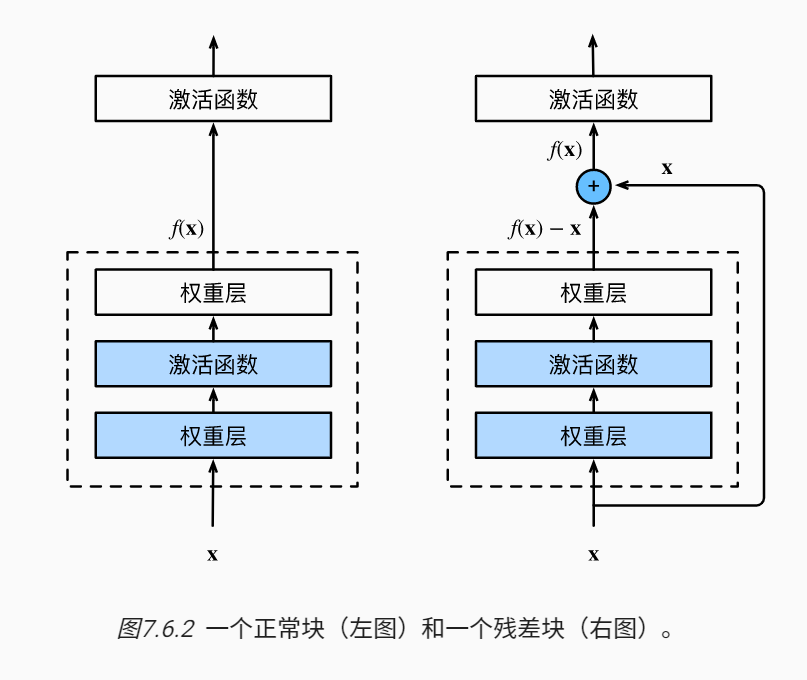

In [45]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\残差块.png",width=700,height=400)

残差块的实现
下面的代码有两种残差块，一种在跳跃连接中不含卷积层，一种在跳跃连接中含有1X1的卷积层调整通道数和分辨率

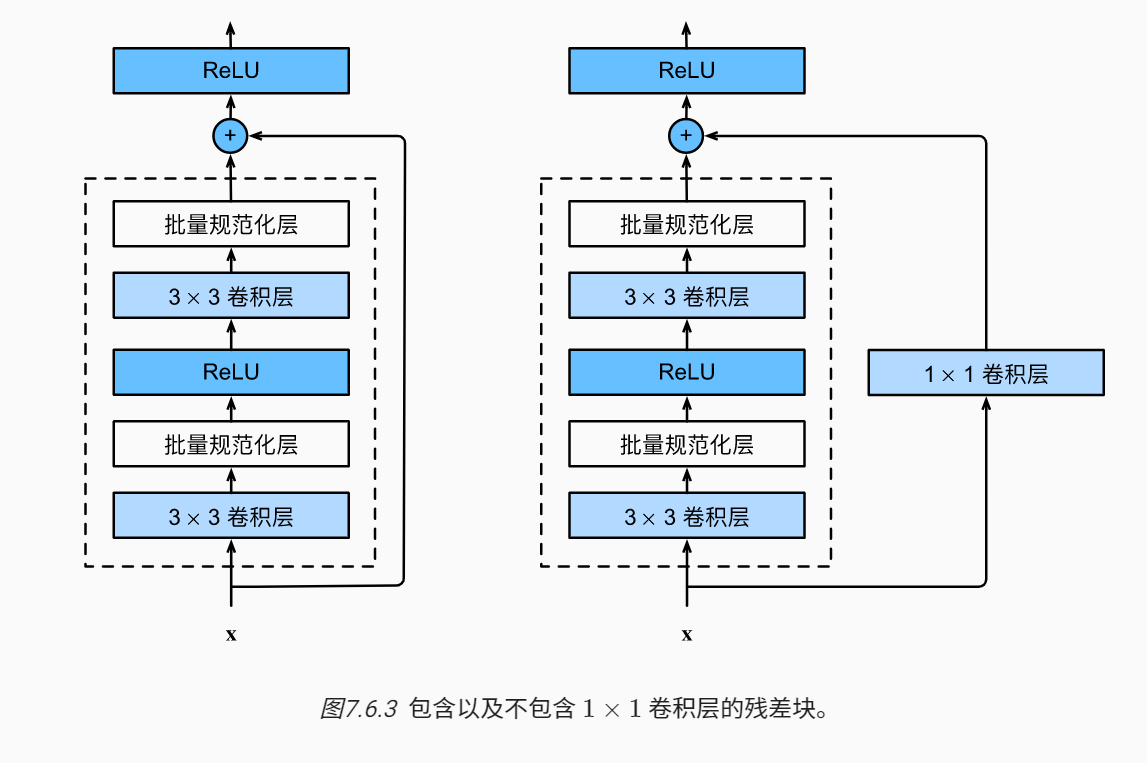

In [53]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\两种残差块.png",width=700,height=800)

In [54]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

## 7.6.2 ResNet的构架——以ResNet-18为例

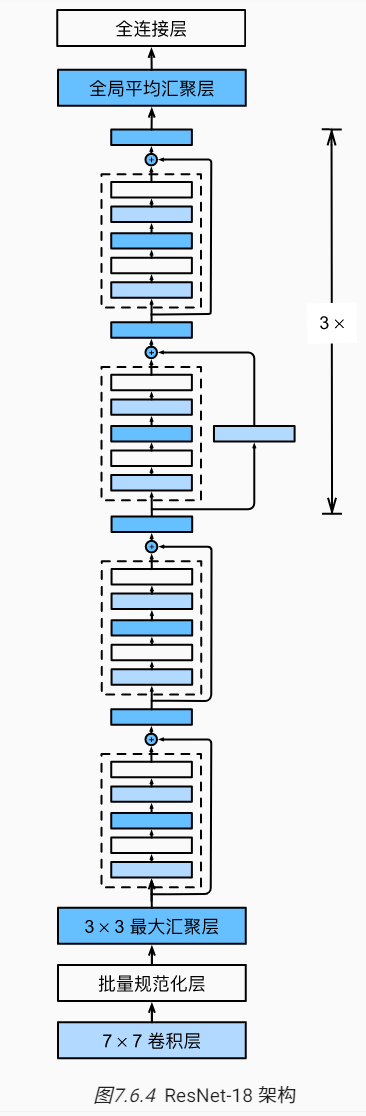

In [19]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\ResNet.png",width=400,height=400)

## 7.6.3 ResNet实现代码

In [55]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [56]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [57]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [58]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [59]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.009, train acc 0.998, test acc 0.905
1552.2 examples/sec on cuda:0


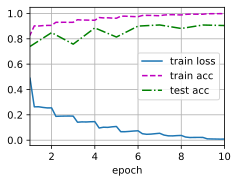

In [38]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.7 稠密连接网络 DenseNet

## 7.7.1 核心——重复利用前面步骤的信息

### 优点：
1. 传播和预测都保留了低层次的特征，加强了特征的利用
2. 相较于ResNet参数更少，相较于其他网络效果好

### 缺点：
训练时间长

## 7.7.2 ResNet与DenseNet的联系

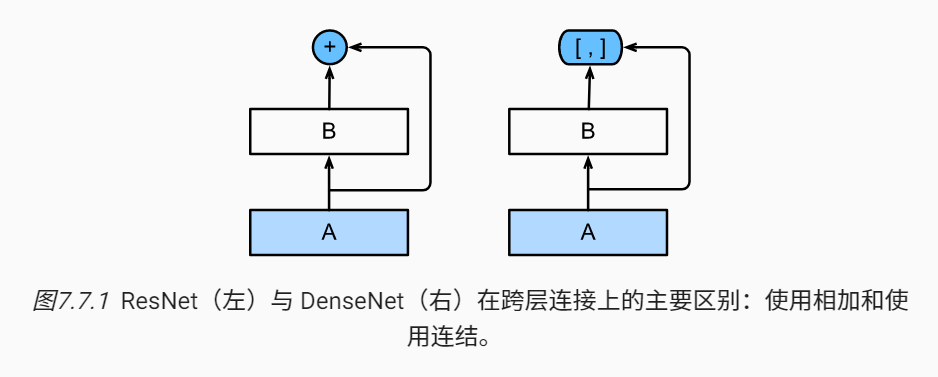

In [48]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\DN与RN的区别.png",width=700,height=400)

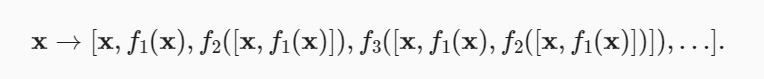

In [1]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\DN公式.png",width=600,height=400)

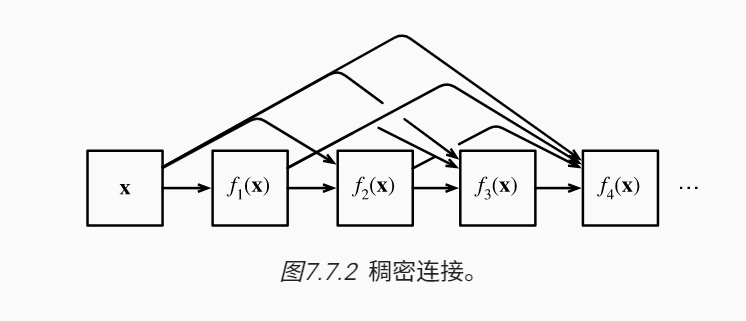

In [50]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\稠密连接.png",width=600,height=400)

## 7.7.3 稠密块体的代码实现

In [60]:
import torch
from torch import nn
from d2l import torch as d2l


# 定义卷积块
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))


# 定义稠密块体
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出 torch.cat是用于拼接的函数
            X = torch.cat((X, Y), dim=1)  
        return X

In [61]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

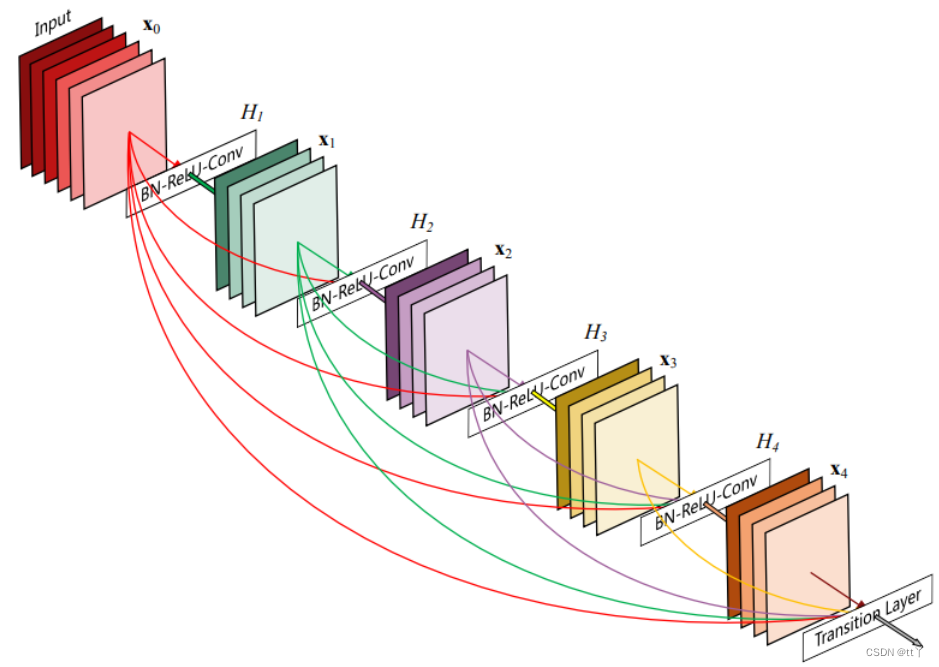

In [63]:
from IPython.display import Image
Image(filename="C:\\Users\\Rickey\\Desktop\\稠密块程序.png",width=600,height=400)

通道数会增长，所以需要通过过渡层用1X1卷积层来减小通道数

In [64]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [65]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## 7.7.4 DenseNet模型及其实现

In [66]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [67]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [68]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [2]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

NameError: name 'load_data_fashion_mnist' is not defined